# A lighter sandbox for quick development and ensembling of components
## Currently in progress: pipeline for route shape SQL query through Carto
## Objectives:
0. determine which route to use (may have different routes for a given bus line)
1. generate a gpd and a shapefile for route shape
2. plot the route on canvas and on gmap API

# Next Tasks:
[o] Allow direction specification in plot_tsd

[o] Plot CallDistanceAlongRoute (Done)

[x] Filter out layover records

[x] Fix durations: time elapsed -> timestamps

[x] Timezone ['RecordedAtTime'] : in data pipeline sandbox

[x] Pack the stuff here into functions

In [62]:
# import packages
from __future__ import print_function, division

import os
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import calendar
from datetime import datetime

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Yuwen/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'test', 'shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [63]:
# import with py 2 and py 3 compatibility
try:
    import urllib2
    from urllib2 import HTTPError
    from urllib2 import urlopen
    from urllib import urlencode
    from StringIO import StringIO as io

except ImportError:
    import urllib
    from urllib.error import HTTPError
    from urllib.request import urlopen, Request
    from urllib.parse import urlencode
    from io import BytesIO as io

import ast

In [64]:
import fiona
import geopandas as gpd
from shapely.geometry import Point

In [65]:
from fetchbus import bus_data, plot_tsd

# 0. Read data

In [34]:
# load historical AVL data
df = pd.read_csv("M1-Tue-180403-230230-100.csv")
df.head()

,Unnamed: 0,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,PresentableDistance,ProgressRate,ProgressStatus,PublishedLineName,RecordedAtTime,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber
0,0,53.808422,MTA NYCT_OF_B8-Weekday_C_OF_56160_M1-109,3859.94,2018-04-03,MTA NYCT_OF_B8-Weekday-136500_M7_242,HARLEM 147 ST via MADISON,MTA_803003,0,12.06,...,at stop,normalProgress,NaN,M1,2018-04-03T23:02:28.000-04:00,MADISON AV/E 55 ST,MTA_400362,0,MTA NYCT_6770,1
1,1,337.077120,MTA NYCT_OF_B8-Weekday_C_OF_25260_M1-111,12340.19,2018-04-03,MTA NYCT_OF_B8-Weekday-130500_M7_243,HARLEM 147 ST via MADISON,MTA_803003,0,25.14,...,at stop,noProgress,layover,M1,2018-04-03T23:02:27.000-04:00,146 ST/LENOX AV,MTA_803003,0,MTA NYCT_3882,1
2,2,233.885240,MTA NYCT_OF_B8-Weekday_C_OF_57060_M1-154,9805.01,2018-04-03,MTA NYCT_OF_B8-Weekday-131500_M7_244,E VILLAGE 8 ST via 5 AV,MTA_403793,1,142.89,...,approaching,normalProgress,NaN,M1,2018-04-03T23:02:09.667-04:00,5 AV/W 33 ST,MTA_400324,0,MTA NYCT_3831,1
3,3,233.918930,MTA NYCT_OF_B8-Weekday_C_OF_46800_M1-134,6718.93,2018-04-03,MTA NYCT_OF_B8-Weekday-135500_M1_148,E VILLAGE 8 ST via 5 AV,MTA_403793,1,195.90,...,< 1 stop away,normalProgress,NaN,M1,2018-04-03T23:02:23.000-04:00,5 AV/E 72 ST,MTA_400124,0,MTA NYCT_6757,1
4,4,53.794224,MTA NYCT_OF_B8-Weekday_C_OF_52620_M7-205,5211.70,2018-04-03,MTA NYCT_OF_B8-Weekday-134500_M1_151,HARLEM 147 ST via MADISON,MTA_803003,0,259.43,...,< 1 stop away,normalProgress,NaN,M1,2018-04-03T23:02:20.000-04:00,MADISON AV/E 72 ST,MTA_400030,0,MTA NYCT_3886,1


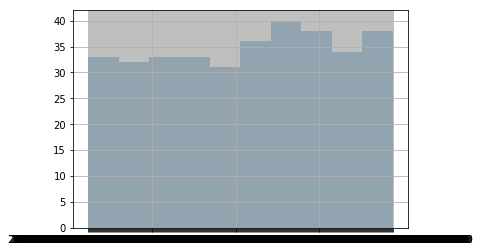

In [36]:
# inspect update times
df = df[df['DirectionRef'] == 1]
df['RecordedAtTime'].hist()

#df2 = df.sort_values('RecordedAtTime')
#df2['RecordedAtTime'].diff()

#len(df['CallDistanceAlongRoute'].unique())

# 1. Plot Time-space Diagram

In [54]:
# function for plotting time-space diagram
def plot_tsd(df, dir_ref=0, start_min=None, end_min=None, save=False, fname='TSD'):
    """
    Plot the time-space diagram for a given dataframe containing
    real-time MTA bus data (as generated from fetchbus.py)
    PARAMETERS
    ----------
    df: pd.DataFrame
        Input dataframe containing required columns for plotting time-space diagram.
    dir_ref: integer (0 or 1)
        The direction to be plotted.
    start_min: numeric
        Plot from this given minute (time elapsed).
    end_min: numeric
        Plot until this given minute (time elapsed).
    save: boolean
        Save TSD to .png at current directory.
    fname: string
        Assign a filename for saved TSD (otherwise may be overwritten).
        
    RETURNS
    -------
    fig:
    ax:
    filename.png: png
        a saved TSD file (optional)
    """
    # determine time interval to be plotted
    try:
        s = start_min * 2 # * 60 sec / 30 sec interval
        e = end_min * 2
    except:
        s = start_min
        e = end_min
    
    # subset df for given direction
    df = df[df['DirectionRef'] == dir_ref]
    
    # convert time format
    df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])

    # plot figure
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    
    # calculate vehicle distance along the route
    df['VehDistAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']
    
    # plot the trajectory for each vehicle
    for i, v in enumerate(df['VehicleRef'].unique()):
        # subset data for single vehicle
        veh_df = df[df['VehicleRef'] == v]
        # subset within specified time window
        veh_df = veh_df.iloc[s:e,:]
        
        # plot CallDistanceAlongRoute (bus stops)
        [ax.plot([df['RecordedAtTime'].min(), df['RecordedAtTime'].max()], [i, i], color='gray', alpha=0.1) for i in df['CallDistanceAlongRoute'].unique()]
        
        ax.plot(veh_df['RecordedAtTime'], veh_df['VehDistAlongRoute'], marker='.')
        ax.annotate('%s'%v.split("_")[1], (list(veh_df['RecordedAtTime'])[0],list(veh_df['VehDistAlongRoute'])[0]))
        
        ax.grid()
        ax.set_xlabel("time", fontsize=14)
        ax.set_ylabel("distance along route (m)", fontsize=14)
        ax.set_title("Time-space Diagram", fontsize=18)
    
    plt.tight_layout()
    
    # save figure locally if specified
    if save:
        plt.savefig("%s.png"%(fname), dpi=300)
    else:
        pass
    plt.show()
    
    return fig, ax

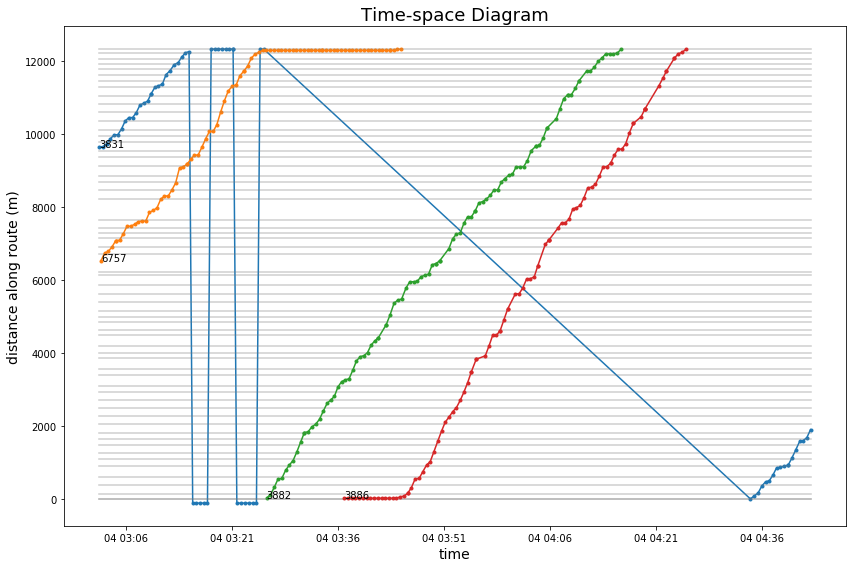

(<matplotlib.figure.Figure at 0x126d7ec50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126d61da0>)

In [55]:
plot_tsd(df, 1, save=True, fname='TSD_test')

# 2. Route Line Topology Plotting

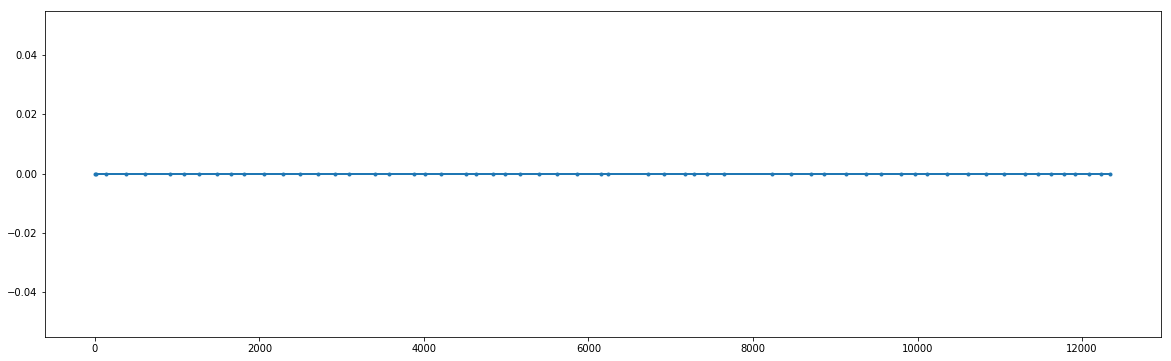

In [147]:
stops_x = df['CallDistanceAlongRoute'].unique()
stops_y = [0] * len(stops_x)

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(stops_x, stops_y, 'o-', markersize=3)

# 3. Route Shape Plotting on Map

In [60]:
# set SQL source
SQL_SOURCE = 'https://ywc249.carto.com/api/v2/sql?q='

# define query function
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """
    Queries carto datasets from a given carto account
    
    ARGUMENTS
    ----------
    query: a valid sql query string
    format: outlut format (default: CSV)
    source: a valid sql api endpoint OPTIONAL (default: Carto ywc249 account)

    RETURN
    ----------
    - the return of the sql query AS A STRING
    
    NOTES
    ----------
    designed for the carto API, tested only with CSV return format
    """
    
    data = urlencode({'format':format, 'q':query}).encode('utf-8')
    try:
        response = urlopen(source, data)
    except HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [148]:
df = pd.read_csv("M96-Sat-180407-000718-10.csv")
df.head()

,Unnamed: 0,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,PresentableDistance,ProgressRate,ProgressStatus,PublishedLineName,RecordedAtTime,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber
0,0,157.07460,MTA NYCT_MV_B8-Weekday_C_MV_53460_M96-33,2895.96,2018-04-06,MTA NYCT_MV_B8-Weekday-143000_M96_37,EAST SIDE 1 AV CROSSTOWN,MTA_903003,0,20.31,...,at stop,normalProgress,NaN,M96,2018-04-07T00:07:16.000-04:00,E 97 ST/1 AV,MTA_903003,0,MTA NYCT_6697,1
1,1,337.10397,MTA NYCT_MV_B8-Weekday_C_MV_25200_M96-11,258.65,2018-04-06,MTA NYCT_MV_B8-Weekday-144500_M96_35,EAST SIDE 1 AV CROSSTOWN,MTA_903003,0,51.97,...,approaching,normalProgress,NaN,M96,2018-04-07T00:06:53.000-04:00,W 96 ST/AMSTERDAM AV,MTA_401935,0,MTA NYCT_3859,1
2,2,53.96758,NaN,1098.83,2018-04-06,MTA NYCT_MV_B8-Weekday-144000_M96_36,WEST SIDE WEST END AV CROSSTOWN,MTA_903004,1,173.73,...,< 1 stop away,normalProgress,NaN,M96,2018-04-07T00:06:51.000-04:00,E 97 ST/5 AV,MTA_401961,0,MTA NYCT_3849,1
3,0,157.07460,MTA NYCT_MV_B8-Weekday_C_MV_53460_M96-33,2895.96,2018-04-06,MTA NYCT_MV_B8-Weekday-143000_M96_37,EAST SIDE 1 AV CROSSTOWN,MTA_903003,0,20.31,...,at stop,normalProgress,NaN,M96,2018-04-07T00:07:16.000-04:00,E 97 ST/1 AV,MTA_903003,0,MTA NYCT_6697,1
4,1,53.96758,NaN,1098.83,2018-04-06,MTA NYCT_MV_B8-Weekday-144000_M96_36,WEST SIDE WEST END AV CROSSTOWN,MTA_903004,1,161.32,...,< 1 stop away,normalProgress,NaN,M96,2018-04-07T00:07:23.000-04:00,E 97 ST/5 AV,MTA_401961,0,MTA NYCT_3849,1


In [149]:
df['DatedVehicleJourneyRef'].unique()

array(['MTA NYCT_MV_B8-Weekday-143000_M96_37',
       'MTA NYCT_MV_B8-Weekday-144500_M96_35',
       'MTA NYCT_MV_B8-Weekday-144000_M96_36',
       'MTA NYCT_MV_B8-Weekday-145200_M96_37'], dtype=object)

In [150]:
df['DatedVehicleJourneyRef'].unique()
df['DatedVehicleJourneyRef'].value_counts().idxmax()[9:]

'MV_B8-Weekday-144000_M96_36'

## Issue: Multiple routes and shapes
current workaround: select the most common one

In [166]:
# make query for a given route
# the shape.txt files are pre-uploaded to my Carto space as csv files

route = df['PublishedLineName'].unique()[0]
boro = route[0].lower() # make query from respecttive GTFS shape csv
trip_id = df['DatedVehicleJourneyRef'].value_counts().idxmax()[9:]

q_shape = '''
SELECT *
FROM shapes_{0}
WHERE shape_id = (
  SELECT shape_id
  FROM trips_{0}
  WHERE trip_id = '{1}')
ORDER BY shape_pt_sequence
'''.format(boro, trip_id)

q_stop = '''
query stops shapefile here
'''

In [167]:
q_shape

"\nSELECT *\nFROM shapes_m\nWHERE shape_id = (\n  SELECT shape_id\n  FROM trips_m\n  WHERE trip_id = 'MV_B8-Weekday-144000_M96_36')\nORDER BY shape_pt_sequence\n"

In [168]:
r_shape = pd.read_csv(io(queryCartoDB(q_shape)), sep=',')
r_shape.head()

,the_geom,cartodb_id,the_geom_webmercator,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,NaN,19905,NaN,M960076,40.784484,-73.945522,10001
1,NaN,19906,NaN,M960076,40.784870,-73.946423,10002
2,NaN,19907,NaN,M960076,40.784870,-73.946423,20001
3,NaN,19908,NaN,M960076,40.784941,-73.946589,20002
4,NaN,19909,NaN,M960076,40.784357,-73.947008,20003


In [169]:
# create Point geom
r_shape['geometry'] = [Point(r_shape.iloc[i,5], r_shape.iloc[i,4]) for i in range(len(r_shape))]
r_shape.head()

,the_geom,cartodb_id,the_geom_webmercator,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,geometry
0,NaN,19905,NaN,M960076,40.784484,-73.945522,10001,POINT (-73.945522 40.784484)
1,NaN,19906,NaN,M960076,40.784870,-73.946423,10002,POINT (-73.946423 40.78487)
2,NaN,19907,NaN,M960076,40.784870,-73.946423,20001,POINT (-73.946423 40.78487)
3,NaN,19908,NaN,M960076,40.784941,-73.946589,20002,POINT (-73.946589 40.784941)
4,NaN,19909,NaN,M960076,40.784357,-73.947008,20003,POINT (-73.947008 40.784357)


# Issue: import gmap

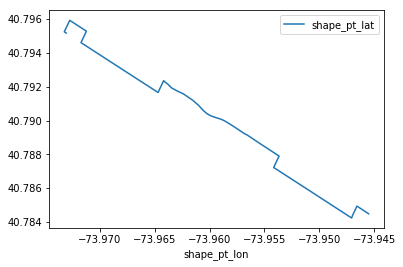

In [170]:
r_shape.plot('shape_pt_lon', 'shape_pt_lat')

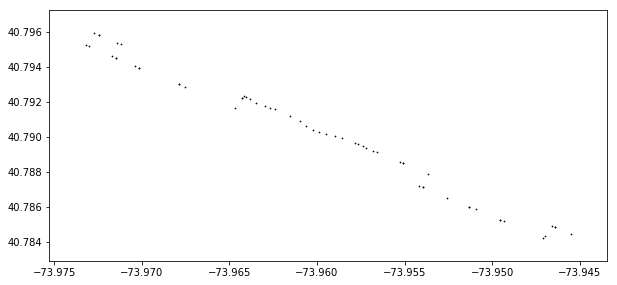

In [171]:
shape_gdf = gpd.GeoDataFrame(r_shape)
shape_gdf.plot(facecolor='r', edgecolor='k', markersize=0.5, figsize=(10,10))

# Random Notes

In [25]:
# this is a fix patch for previous versions of downloaded data
mod = list(df['Unnamed: 0'])
tiempo = 0
ts = []
for i,v in enumerate(mod[:-1]):
    ts.append(tiempo)
    if mod[i+1] < mod[i]:
        tiempo += 30
    else:
        continue
ts.append(ts[-1])
df['ts'] = ts

In [ ]:
#for r, d in data.iterrows():